# Optimization of TLN using differentiable simulation - with mismatch

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Library imports
import numpy as np
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt

from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
import diffrax as dr
import sympy as sp

from typing import Dict

In [3]:
# Local imports
from ark.cdg.cdg import CDG, CDGNode
from ark.compiler import ArkCompiler
from ark.rewrite import RewriteGen, SympyRewriteGen
from ark.solver import SMTSolver
from ark.specification.cdg_types import NodeType, EdgeType
from ark.validator import ArkValidator
from spec import pulse_sympy
from tln_example import create_tline_branch, IdealV, IdealI, IdealE

## Generate a TLN graph from specification

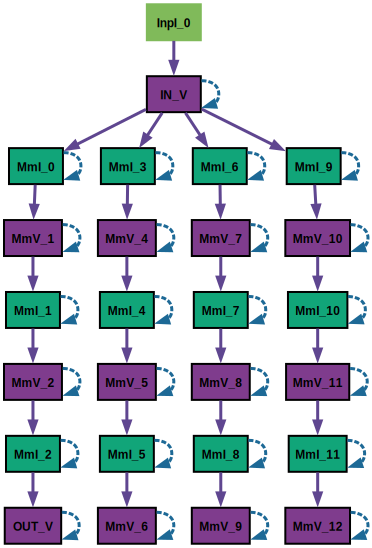

In [25]:
from ark.specification.specification import CDGSpec
from examples.tln.tln_example import make_full_graph

# branch_args = {
#     "line_len": 4,
#     "branch_stride": 4,
#     "branches_per_node": 5,
#     "branch_len": 4,
#     "branch_offset": 0,
# }

def make_hub_and_spoke(num_spokes: int, spoke_length: int, mismatch=True) -> tuple[CDG, CDGSpec]:
    return make_full_graph(mismatch=mismatch, branch_args_override={
        'line_len': spoke_length,
        'branch_stride': spoke_length,
        'branches_per_node': num_spokes,
        'branch_len': spoke_length - 1,
        'branch_offset': 0,
    })


# graph, spec = make_full_graph(mismatch=True,
#                               branch_args_override=branch_args)
graph, spec = make_hub_and_spoke(num_spokes=3, spoke_length=3, mismatch=True)

from ark.visualize.graphviz_gen import cdg_to_graphviz_display
cdg_to_graphviz_display(cdg_lang=spec, cdg=graph)

Now we have a graph with representing the TLN with certain arguments, and can compile it to SymPy expressions.

In [26]:
compiler = ArkCompiler(rewrite=SympyRewriteGen())
sympy_pairs = compiler.compile_sympy(cdg=graph, cdg_spec=spec, help_fn=[])

Compiling order 1 nodes: 100%|██████████| 25/25 [00:00<00:00, 853.56it/s]


In [27]:
sympy_pairs

[(ddt_IN_V,
  -IN_V*IN_V_g/IN_V_c - MmE_0_ws*MmI_0/IN_V_c - MmE_22_ws*MmI_3/IN_V_c - MmE_24_ws*MmI_6/IN_V_c - MmE_26_ws*MmI_9/IN_V_c + MmE_27_wt*(-IN_V*InpI_0_g + InpI_0_fn(time))/IN_V_c),
 (ddt_MmI_0,
  IN_V*MmE_0_wt/MmI_0_l - MmE_1_ws*MmV_1/MmI_0_l - MmI_0*MmI_0_r/MmI_0_l),
 (ddt_MmI_1,
  MmE_2_wt*MmV_1/MmI_1_l - MmE_3_ws*MmV_2/MmI_1_l - MmI_1*MmI_1_r/MmI_1_l),
 (ddt_MmI_10,
  MmE_17_wt*MmV_10/MmI_10_l - MmE_18_ws*MmV_11/MmI_10_l - MmI_10*MmI_10_r/MmI_10_l),
 (ddt_MmI_11,
  MmE_19_wt*MmV_11/MmI_11_l - MmE_20_ws*MmV_12/MmI_11_l - MmI_11*MmI_11_r/MmI_11_l),
 (ddt_MmI_2,
  MmE_4_wt*MmV_2/MmI_2_l - MmE_5_ws*OUT_V/MmI_2_l - MmI_2*MmI_2_r/MmI_2_l),
 (ddt_MmI_3,
  IN_V*MmE_22_wt/MmI_3_l - MmE_6_ws*MmV_4/MmI_3_l - MmI_3*MmI_3_r/MmI_3_l),
 (ddt_MmI_4,
  MmE_7_wt*MmV_4/MmI_4_l - MmE_8_ws*MmV_5/MmI_4_l - MmI_4*MmI_4_r/MmI_4_l),
 (ddt_MmI_5,
  -MmE_10_ws*MmV_6/MmI_5_l + MmE_9_wt*MmV_5/MmI_5_l - MmI_5*MmI_5_r/MmI_5_l),
 (ddt_MmI_6,
  IN_V*MmE_24_wt/MmI_6_l - MmE_11_ws*MmV_7/MmI_6_l - MmI_6*MmI_6_

We can now convert these into a set of differential equations, using some amount of parsing.

In [28]:
def collapse_derivative(pair: tuple[sp.Symbol, sp.Expr]) -> sp.Eq:
    """Turns tuple of derivative + sympy expression into a single sympy equation."""
    if (var_name := pair[0].name).startswith('ddt_'):
        symbol = sp.symbols(var_name[4:])
        equation = sp.Eq(sp.Derivative(symbol, sp.symbols('time')), pair[1])
        return equation.subs(sp.symbols('time'), sp.symbols('t'))
    else:
        raise ValueError("Not a derivative expression.")
sympy_eqs = [collapse_derivative(pair) for pair in sympy_pairs]
sympy_eqs

[Eq(Derivative(IN_V, t), -IN_V*IN_V_g/IN_V_c - MmE_0_ws*MmI_0/IN_V_c - MmE_22_ws*MmI_3/IN_V_c - MmE_24_ws*MmI_6/IN_V_c - MmE_26_ws*MmI_9/IN_V_c + MmE_27_wt*(-IN_V*InpI_0_g + InpI_0_fn(t))/IN_V_c),
 Eq(Derivative(MmI_0, t), IN_V*MmE_0_wt/MmI_0_l - MmE_1_ws*MmV_1/MmI_0_l - MmI_0*MmI_0_r/MmI_0_l),
 Eq(Derivative(MmI_1, t), MmE_2_wt*MmV_1/MmI_1_l - MmE_3_ws*MmV_2/MmI_1_l - MmI_1*MmI_1_r/MmI_1_l),
 Eq(Derivative(MmI_10, t), MmE_17_wt*MmV_10/MmI_10_l - MmE_18_ws*MmV_11/MmI_10_l - MmI_10*MmI_10_r/MmI_10_l),
 Eq(Derivative(MmI_11, t), MmE_19_wt*MmV_11/MmI_11_l - MmE_20_ws*MmV_12/MmI_11_l - MmI_11*MmI_11_r/MmI_11_l),
 Eq(Derivative(MmI_2, t), MmE_4_wt*MmV_2/MmI_2_l - MmE_5_ws*OUT_V/MmI_2_l - MmI_2*MmI_2_r/MmI_2_l),
 Eq(Derivative(MmI_3, t), IN_V*MmE_22_wt/MmI_3_l - MmE_6_ws*MmV_4/MmI_3_l - MmI_3*MmI_3_r/MmI_3_l),
 Eq(Derivative(MmI_4, t), MmE_7_wt*MmV_4/MmI_4_l - MmE_8_ws*MmV_5/MmI_4_l - MmI_4*MmI_4_r/MmI_4_l),
 Eq(Derivative(MmI_5, t), -MmE_10_ws*MmV_6/MmI_5_l + MmE_9_wt*MmV_5/MmI_5_l - MmI_5*

Now we need to substitute the forcing function `InpI_0_fn` into a pulse function (a piecewise function defined in SymPy).

In [29]:
t = sp.symbols('t')
InpI_0_fn = sp.Function('InpI_0_fn')
replaced_function = sympy_eqs[0].subs(InpI_0_fn(t), pulse_sympy(t))
replaced_function

Eq(Derivative(IN_V, t), -IN_V*IN_V_g/IN_V_c - MmE_0_ws*MmI_0/IN_V_c - MmE_22_ws*MmI_3/IN_V_c - MmE_24_ws*MmI_6/IN_V_c - MmE_26_ws*MmI_9/IN_V_c + MmE_27_wt*(-IN_V*InpI_0_g + Piecewise((200000000.0*(Mod(t, 1)), Mod(t, 1) < 5.0e-9), (1, Mod(t, 1) < 1.5e-8), (4.0 - 200000000.0*Mod(t, 1), Mod(t, 1) < 2.0e-8), (0, True)))/IN_V_c)

In [30]:
sympy_eqs_expanded = [replaced_function if i == 0 else f for i, f in enumerate(sympy_eqs)]

In [31]:
sympy_eqs_expanded

[Eq(Derivative(IN_V, t), -IN_V*IN_V_g/IN_V_c - MmE_0_ws*MmI_0/IN_V_c - MmE_22_ws*MmI_3/IN_V_c - MmE_24_ws*MmI_6/IN_V_c - MmE_26_ws*MmI_9/IN_V_c + MmE_27_wt*(-IN_V*InpI_0_g + Piecewise((200000000.0*(Mod(t, 1)), Mod(t, 1) < 5.0e-9), (1, Mod(t, 1) < 1.5e-8), (4.0 - 200000000.0*Mod(t, 1), Mod(t, 1) < 2.0e-8), (0, True)))/IN_V_c),
 Eq(Derivative(MmI_0, t), IN_V*MmE_0_wt/MmI_0_l - MmE_1_ws*MmV_1/MmI_0_l - MmI_0*MmI_0_r/MmI_0_l),
 Eq(Derivative(MmI_1, t), MmE_2_wt*MmV_1/MmI_1_l - MmE_3_ws*MmV_2/MmI_1_l - MmI_1*MmI_1_r/MmI_1_l),
 Eq(Derivative(MmI_10, t), MmE_17_wt*MmV_10/MmI_10_l - MmE_18_ws*MmV_11/MmI_10_l - MmI_10*MmI_10_r/MmI_10_l),
 Eq(Derivative(MmI_11, t), MmE_19_wt*MmV_11/MmI_11_l - MmE_20_ws*MmV_12/MmI_11_l - MmI_11*MmI_11_r/MmI_11_l),
 Eq(Derivative(MmI_2, t), MmE_4_wt*MmV_2/MmI_2_l - MmE_5_ws*OUT_V/MmI_2_l - MmI_2*MmI_2_r/MmI_2_l),
 Eq(Derivative(MmI_3, t), IN_V*MmE_22_wt/MmI_3_l - MmE_6_ws*MmV_4/MmI_3_l - MmI_3*MmI_3_r/MmI_3_l),
 Eq(Derivative(MmI_4, t), MmE_7_wt*MmV_4/MmI_4_l - Mm

In [32]:
# Find all the LHS variables in the set of equations
lhs_vars = [list(eq.lhs.free_symbols)[0] for eq in sympy_eqs_expanded]
lhs_vars

[IN_V,
 MmI_0,
 MmI_1,
 MmI_10,
 MmI_11,
 MmI_2,
 MmI_3,
 MmI_4,
 MmI_5,
 MmI_6,
 MmI_7,
 MmI_8,
 MmI_9,
 MmV_1,
 MmV_10,
 MmV_11,
 MmV_12,
 MmV_2,
 MmV_4,
 MmV_5,
 MmV_6,
 MmV_7,
 MmV_8,
 MmV_9,
 OUT_V]

In [33]:
# Figure out which parameters are necessary to evaluate the equations
param_vars = [eq.free_symbols - set(lhs_vars) for eq in sympy_eqs_expanded]
all_param_vars = set().union(*param_vars)
all_param_vars.remove(sp.symbols('t'))
del param_vars
print(f'All parameters:\n{", ".join(map(str, all_param_vars))}')

All parameters:
MmE_9_wt, MmI_5_l, MmV_10_c, MmE_26_ws, MmI_4_l, MmI_8_l, MmE_13_wt, MmE_3_ws, MmV_7_g, MmE_8_ws, MmE_18_ws, MmV_12_c, MmE_5_wt, MmV_6_c, MmI_2_l, MmE_13_ws, MmI_7_r, MmE_4_wt, MmE_19_ws, MmI_0_r, MmV_4_c, MmE_10_ws, MmE_26_wt, MmE_6_wt, MmI_7_l, MmE_16_wt, MmE_22_ws, MmE_12_wt, MmV_4_g, InpI_0_g, MmI_4_r, MmE_10_wt, MmE_15_ws, MmV_1_c, OUT_V_c, MmE_24_wt, MmI_9_r, MmE_1_wt, MmE_7_ws, MmI_8_r, MmE_20_ws, MmV_9_g, MmV_2_c, MmV_5_c, MmE_2_ws, MmV_1_g, MmE_11_ws, MmE_15_wt, MmE_14_ws, MmI_0_l, MmV_11_c, MmI_1_r, MmE_12_ws, MmE_3_wt, MmE_19_wt, MmE_24_ws, MmI_11_l, MmE_8_wt, MmI_1_l, MmE_7_wt, MmE_14_wt, MmV_8_c, MmI_10_r, MmE_0_ws, MmI_3_l, MmE_27_wt, MmE_2_wt, MmE_17_wt, MmE_4_ws, MmE_22_wt, MmI_6_l, MmI_6_r, MmI_3_r, IN_V_g, MmI_5_r, OUT_V_g, MmE_16_ws, MmV_11_g, MmE_9_ws, MmV_9_c, MmE_0_wt, MmE_6_ws, MmE_17_ws, MmI_10_l, MmI_2_r, MmE_20_wt, MmE_1_ws, MmE_11_wt, IN_V_c, MmI_9_l, MmV_2_g, MmV_6_g, MmV_10_g, MmV_7_c, MmV_5_g, MmV_12_g, MmE_18_wt, MmE_5_ws, MmV_8_g, MmI_11_

In [34]:
# Now we gather the parameters necessary from the respective nodes in the graph
def get_param_from_dict(param_name: str) -> float:
    element_name = '_'.join(param_name.split('_')[:-1])
    param_name = param_name.split('_')[-1]
    return graph_param_dict[element_name][param_name]

# Collect all node parameters into a dictionary with dictionary values
node_param_dict = {node.name: node.attrs for node in graph.nodes}
edge_param_dict = {edge.name: edge.attrs for edge in graph.edges}
graph_param_dict = node_param_dict | edge_param_dict

# Gather all necessary parameters in a flat dictionary
param_dict = {k: get_param_from_dict(k.name) for k in all_param_vars}
param_dict

{MmE_9_wt: 1.0,
 MmI_5_l: 1e-09,
 MmV_10_c: 1e-09,
 MmE_26_ws: 1.0,
 MmI_4_l: 1e-09,
 MmI_8_l: 1e-09,
 MmE_13_wt: 1.0,
 MmE_3_ws: 1.0,
 MmV_7_g: 0.0,
 MmE_8_ws: 1.0,
 MmE_18_ws: 1.0,
 MmV_12_c: 1e-09,
 MmE_5_wt: 1.0,
 MmV_6_c: 1e-09,
 MmI_2_l: 1e-09,
 MmE_13_ws: 1.0,
 MmI_7_r: 0.0,
 MmE_4_wt: 1.0,
 MmE_19_ws: 1.0,
 MmI_0_r: 0.0,
 MmV_4_c: 1e-09,
 MmE_10_ws: 1.0,
 MmE_26_wt: 1.0,
 MmE_6_wt: 1.0,
 MmI_7_l: 1e-09,
 MmE_16_wt: 1.0,
 MmE_22_ws: 1.0,
 MmE_12_wt: 1.0,
 MmV_4_g: 0.0,
 InpI_0_g: 1.0,
 MmI_4_r: 0.0,
 MmE_10_wt: 1.0,
 MmE_15_ws: 1.0,
 MmV_1_c: 1e-09,
 OUT_V_c: 1e-09,
 MmE_24_wt: 1.0,
 MmI_9_r: 0.0,
 MmE_1_wt: 1.0,
 MmE_7_ws: 1.0,
 MmI_8_r: 0.0,
 MmE_20_ws: 1.0,
 MmV_9_g: 0.0,
 MmV_2_c: 1e-09,
 MmV_5_c: 1e-09,
 MmE_2_ws: 1.0,
 MmV_1_g: 0.0,
 MmE_11_ws: 1.0,
 MmE_15_wt: 1.0,
 MmE_14_ws: 1.0,
 MmI_0_l: 1e-09,
 MmV_11_c: 1e-09,
 MmI_1_r: 0.0,
 MmE_12_ws: 1.0,
 MmE_3_wt: 1.0,
 MmE_19_wt: 1.0,
 MmE_24_ws: 1.0,
 MmI_11_l: 1e-09,
 MmE_8_wt: 1.0,
 MmI_1_l: 1e-09,
 MmE_7_wt: 1.0,
 MmE_14_w

In [35]:
# Gather initial values for the LHS variables
# TODO(marcelroed): Currently all at zero -- should this change?
lhs_init_dict = {k: 0.0 for k in lhs_vars}

### Reminder of relevant variables

In [36]:
display(sympy_eqs_expanded)  # List of all equations defining the system
display(lhs_vars)  # Names of all left-hand side variables
display(param_dict)  # Mapping of all parameters to be simulated -- are what we want sensitivities for

[Eq(Derivative(IN_V, t), -IN_V*IN_V_g/IN_V_c - MmE_0_ws*MmI_0/IN_V_c - MmE_22_ws*MmI_3/IN_V_c - MmE_24_ws*MmI_6/IN_V_c - MmE_26_ws*MmI_9/IN_V_c + MmE_27_wt*(-IN_V*InpI_0_g + Piecewise((200000000.0*(Mod(t, 1)), Mod(t, 1) < 5.0e-9), (1, Mod(t, 1) < 1.5e-8), (4.0 - 200000000.0*Mod(t, 1), Mod(t, 1) < 2.0e-8), (0, True)))/IN_V_c),
 Eq(Derivative(MmI_0, t), IN_V*MmE_0_wt/MmI_0_l - MmE_1_ws*MmV_1/MmI_0_l - MmI_0*MmI_0_r/MmI_0_l),
 Eq(Derivative(MmI_1, t), MmE_2_wt*MmV_1/MmI_1_l - MmE_3_ws*MmV_2/MmI_1_l - MmI_1*MmI_1_r/MmI_1_l),
 Eq(Derivative(MmI_10, t), MmE_17_wt*MmV_10/MmI_10_l - MmE_18_ws*MmV_11/MmI_10_l - MmI_10*MmI_10_r/MmI_10_l),
 Eq(Derivative(MmI_11, t), MmE_19_wt*MmV_11/MmI_11_l - MmE_20_ws*MmV_12/MmI_11_l - MmI_11*MmI_11_r/MmI_11_l),
 Eq(Derivative(MmI_2, t), MmE_4_wt*MmV_2/MmI_2_l - MmE_5_ws*OUT_V/MmI_2_l - MmI_2*MmI_2_r/MmI_2_l),
 Eq(Derivative(MmI_3, t), IN_V*MmE_22_wt/MmI_3_l - MmE_6_ws*MmV_4/MmI_3_l - MmI_3*MmI_3_r/MmI_3_l),
 Eq(Derivative(MmI_4, t), MmE_7_wt*MmV_4/MmI_4_l - Mm

[IN_V,
 MmI_0,
 MmI_1,
 MmI_10,
 MmI_11,
 MmI_2,
 MmI_3,
 MmI_4,
 MmI_5,
 MmI_6,
 MmI_7,
 MmI_8,
 MmI_9,
 MmV_1,
 MmV_10,
 MmV_11,
 MmV_12,
 MmV_2,
 MmV_4,
 MmV_5,
 MmV_6,
 MmV_7,
 MmV_8,
 MmV_9,
 OUT_V]

{MmE_9_wt: 1.0,
 MmI_5_l: 1e-09,
 MmV_10_c: 1e-09,
 MmE_26_ws: 1.0,
 MmI_4_l: 1e-09,
 MmI_8_l: 1e-09,
 MmE_13_wt: 1.0,
 MmE_3_ws: 1.0,
 MmV_7_g: 0.0,
 MmE_8_ws: 1.0,
 MmE_18_ws: 1.0,
 MmV_12_c: 1e-09,
 MmE_5_wt: 1.0,
 MmV_6_c: 1e-09,
 MmI_2_l: 1e-09,
 MmE_13_ws: 1.0,
 MmI_7_r: 0.0,
 MmE_4_wt: 1.0,
 MmE_19_ws: 1.0,
 MmI_0_r: 0.0,
 MmV_4_c: 1e-09,
 MmE_10_ws: 1.0,
 MmE_26_wt: 1.0,
 MmE_6_wt: 1.0,
 MmI_7_l: 1e-09,
 MmE_16_wt: 1.0,
 MmE_22_ws: 1.0,
 MmE_12_wt: 1.0,
 MmV_4_g: 0.0,
 InpI_0_g: 1.0,
 MmI_4_r: 0.0,
 MmE_10_wt: 1.0,
 MmE_15_ws: 1.0,
 MmV_1_c: 1e-09,
 OUT_V_c: 1e-09,
 MmE_24_wt: 1.0,
 MmI_9_r: 0.0,
 MmE_1_wt: 1.0,
 MmE_7_ws: 1.0,
 MmI_8_r: 0.0,
 MmE_20_ws: 1.0,
 MmV_9_g: 0.0,
 MmV_2_c: 1e-09,
 MmV_5_c: 1e-09,
 MmE_2_ws: 1.0,
 MmV_1_g: 0.0,
 MmE_11_ws: 1.0,
 MmE_15_wt: 1.0,
 MmE_14_ws: 1.0,
 MmI_0_l: 1e-09,
 MmV_11_c: 1e-09,
 MmI_1_r: 0.0,
 MmE_12_ws: 1.0,
 MmE_3_wt: 1.0,
 MmE_19_wt: 1.0,
 MmE_24_ws: 1.0,
 MmI_11_l: 1e-09,
 MmE_8_wt: 1.0,
 MmI_1_l: 1e-09,
 MmE_7_wt: 1.0,
 MmE_14_w

## Defining the DiffEQ solve function


In [37]:
def keys_to_str(d: dict) -> dict:
    return {str(k): v for k, v in d.items()}
keys_to_str(lhs_init_dict)

{'IN_V': 0.0,
 'MmI_0': 0.0,
 'MmI_1': 0.0,
 'MmI_10': 0.0,
 'MmI_11': 0.0,
 'MmI_2': 0.0,
 'MmI_3': 0.0,
 'MmI_4': 0.0,
 'MmI_5': 0.0,
 'MmI_6': 0.0,
 'MmI_7': 0.0,
 'MmI_8': 0.0,
 'MmI_9': 0.0,
 'MmV_1': 0.0,
 'MmV_10': 0.0,
 'MmV_11': 0.0,
 'MmV_12': 0.0,
 'MmV_2': 0.0,
 'MmV_4': 0.0,
 'MmV_5': 0.0,
 'MmV_6': 0.0,
 'MmV_7': 0.0,
 'MmV_8': 0.0,
 'MmV_9': 0.0,
 'OUT_V': 0.0}

Solution(
  t0=f64[],
  t1=f64[],
  ts=f64[100000],
  ys=f64[100000,25],
  interpolation=None,
  stats={
    'max_steps':
    100000,
    'num_accepted_steps':
    i64[],
    'num_rejected_steps':
    i64[],
    'num_steps':
    i64[]
  },
  result=i64[],
  solver_state=None,
  controller_state=None,
  made_jump=None
)

{'max_steps': 100000,
 'num_accepted_steps': Array(74900, dtype=int64, weak_type=True),
 'num_rejected_steps': Array(0, dtype=int64, weak_type=True),
 'num_steps': Array(74900, dtype=int64, weak_type=True)}

Finished getting solution!


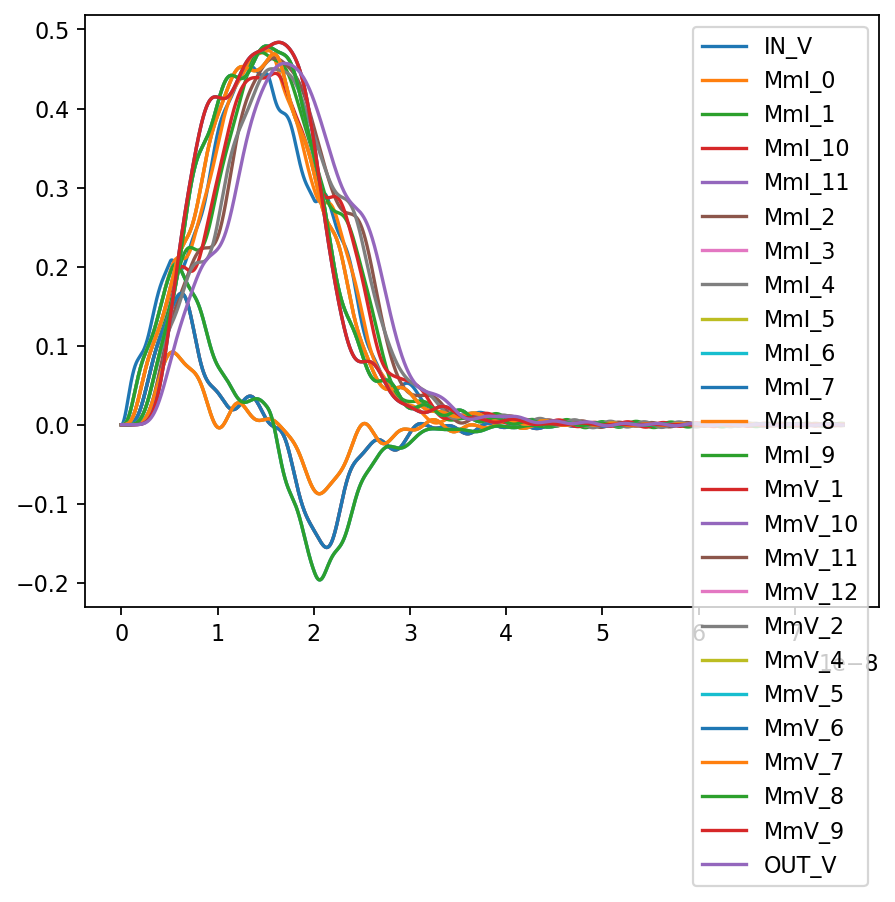

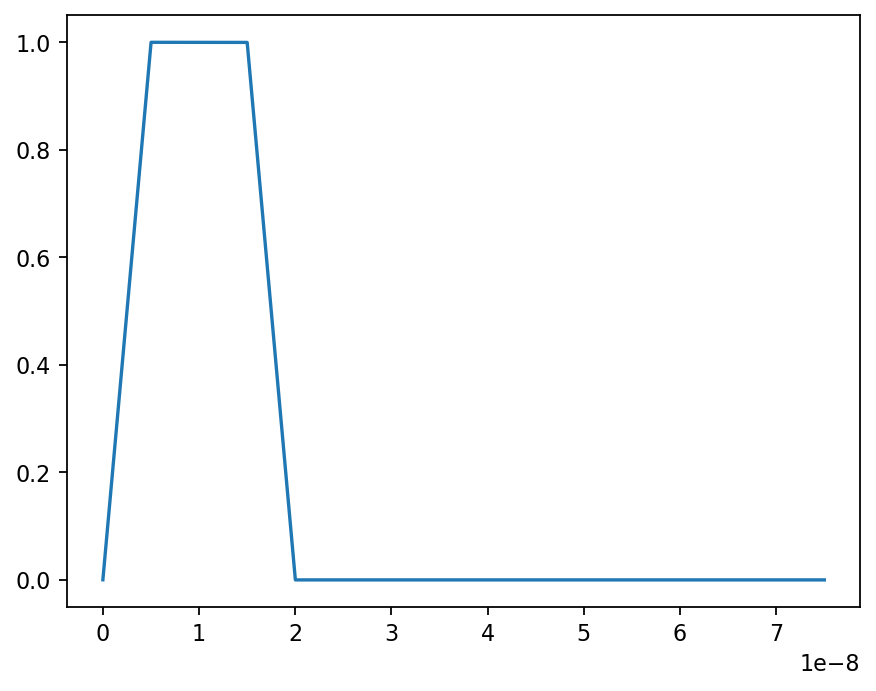

In [39]:
def lambdify_evaluate(expr: sp.Expr, vec_values: dict, parameter_values: dict) -> jax.Array:
    """Lambdifies a sympy equation and evaluates it with the given parameter values."""
    # Lambdify the equation
    free_symbols = list(expr.free_symbols)
    lambdified_eq = sp.lambdify(free_symbols, expr=expr, modules='jax')
    # Evaluate the equation
    evaluation_parameters = {k: parameter_values[k] if k in parameter_values else vec_values[k] for k in map(str, free_symbols)}
    return lambdified_eq(**evaluation_parameters)

@eqx.filter_jit
def solve_system(initial_values: Dict[str, float], parameter_values: Dict[str, float], saveat: dr.SaveAt) -> dict:
    initial_y = jnp.array([initial_values[k] for k in map(str, lhs_vars)])
    def f(t, y, args: dict):
        # Loop through and lambdify all equations
        vec_values = {k: y[i] for i, k in enumerate(map(str, lhs_vars))}
        args_with_t = {**args, 't': t}
        return jnp.array([lambdify_evaluate(expr=eq.rhs, vec_values=vec_values, parameter_values=args_with_t) for eq in sympy_eqs_expanded])
    
    term = dr.ODETerm(f)
    solver = dr.Tsit5()
    system_solution = dr.diffeqsolve(terms=term, solver=solver, t0=0.0, t1=75e-9, dt0=1e-12, y0=initial_y,
                                     args=parameter_values, saveat=saveat, max_steps=100_000)
    return system_solution

solution = solve_system(initial_values=keys_to_str(lhs_init_dict), parameter_values=keys_to_str(param_dict), saveat=dr.SaveAt(steps=True))
display(solution)
display(solution.stats)
jax.block_until_ready(solution.ys)
print('Finished getting solution!')
plt.plot(solution.ts, solution.ys)
plt.legend(lhs_vars)
plt.show()
plt.plot(solution.ts, sp.lambdify(sp.symbols('t'), pulse_sympy(sp.symbols('t')))(solution.ts))
plt.show()

In [ ]:
solution.ts